<a href="https://colab.research.google.com/github/DataScienceAndEngineering/deep-learning-final-project-project-sidewalk/blob/main/notebooks/Nick/SAM_tensorflow_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2ed4d3nj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2ed4d3nj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=8275e4da7b72d2ae0ba881a643dbec970caf82cb881dd9e5e3b751ebd2cc5454
  Stored in directory: /tmp/pip-ephem-wheel-cache-0be0r7mx/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 31.5 MB/s eta 0:0

In [ ]:
from segment_anything import SamPredictor, sam_model_registry
import os
if not os.path.isfile('/content/sam_vit_h_4b8939.pth'):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam = sam_model_registry["vit_h"](checkpoint='/content/sam_vit_h_4b8939.pth')


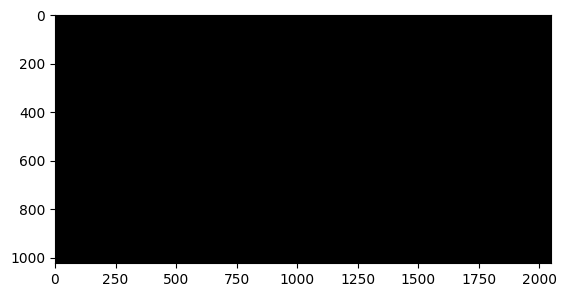

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
dummy_input = np.zeros((1024, 2048, 3))
plt.imshow(dummy_input)

In [ ]:
import torch
dummy_input = torch.randn(1, 1024, 2048, 3)
torch.onnx.export(sam, dummy_input, 'sam.onnx', verbose=False, opset_version=17, input_names='input', output_names='output', export_params=True)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



TypeError: ignored

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch

from segment_anything import sam_model_registry
from segment_anything.utils.onnx import SamOnnxModel

import argparse
import warnings

try:
    import onnxruntime  # type: ignore

    onnxruntime_exists = True
except ImportError:
    onnxruntime_exists = False

parser = argparse.ArgumentParser(
    description="Export the SAM prompt encoder and mask decoder to an ONNX model."
)

parser.add_argument(
    "--checkpoint", type=str, required=True, help="The path to the SAM model checkpoint."
)

parser.add_argument(
    "--output", type=str, required=True, help="The filename to save the ONNX model to."
)

parser.add_argument(
    "--model-type",
    type=str,
    required=True,
    help="In ['default', 'vit_h', 'vit_l', 'vit_b']. Which type of SAM model to export.",
)

parser.add_argument(
    "--return-single-mask",
    action="store_true",
    help=(
        "If true, the exported ONNX model will only return the best mask, "
        "instead of returning multiple masks. For high resolution images "
        "this can improve runtime when upscaling masks is expensive."
    ),
)

parser.add_argument(
    "--opset",
    type=int,
    default=17,
    help="The ONNX opset version to use. Must be >=11",
)

parser.add_argument(
    "--quantize-out",
    type=str,
    default=None,
    help=(
        "If set, will quantize the model and save it with this name. "
        "Quantization is performed with quantize_dynamic from onnxruntime.quantization.quantize."
    ),
)

parser.add_argument(
    "--gelu-approximate",
    action="store_true",
    help=(
        "Replace GELU operations with approximations using tanh. Useful "
        "for some runtimes that have slow or unimplemented erf ops, used in GELU."
    ),
)

parser.add_argument(
    "--use-stability-score",
    action="store_true",
    help=(
        "Replaces the model's predicted mask quality score with the stability "
        "score calculated on the low resolution masks using an offset of 1.0. "
    ),
)

parser.add_argument(
    "--return-extra-metrics",
    action="store_true",
    help=(
        "The model will return five results: (masks, scores, stability_scores, "
        "areas, low_res_logits) instead of the usual three. This can be "
        "significantly slower for high resolution outputs."
    ),
)


def run_export(
    model_type: str,
    checkpoint: str,
    output: str,
    opset: int,
    return_single_mask: bool,
    gelu_approximate: bool = False,
    use_stability_score: bool = False,
    return_extra_metrics=False,
):
    print("Loading model...")
    sam = sam_model_registry[model_type](checkpoint=checkpoint)

    onnx_model = SamOnnxModel(
        model=sam,
        return_single_mask=return_single_mask,
        use_stability_score=use_stability_score,
        return_extra_metrics=return_extra_metrics,
    )

    if gelu_approximate:
        for n, m in onnx_model.named_modules():
            if isinstance(m, torch.nn.GELU):
                m.approximate = "tanh"

    dynamic_axes = {
        "point_coords": {1: "num_points"},
        "point_labels": {1: "num_points"},
    }

    embed_dim = sam.prompt_encoder.embed_dim
    embed_size = sam.prompt_encoder.image_embedding_size
    mask_input_size = [4 * x for x in embed_size]
    dummy_inputs = {
        "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
        "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
        "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
        "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
        "has_mask_input": torch.tensor([1], dtype=torch.float),
        "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
    }

    _ = onnx_model(**dummy_inputs)

    output_names = ["masks", "iou_predictions", "low_res_masks"]

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        with open(output, "wb") as f:
            print(f"Exporting onnx model to {output}...")
            torch.onnx.export(
                onnx_model,
                tuple(dummy_inputs.values()),
                f,
                export_params=True,
                verbose=False,
                opset_version=opset,
                do_constant_folding=True,
                input_names=list(dummy_inputs.keys()),
                output_names=output_names,
                dynamic_axes=dynamic_axes,
            )

    if onnxruntime_exists:
        ort_inputs = {k: to_numpy(v) for k, v in dummy_inputs.items()}
        # set cpu provider default
        providers = ["CPUExecutionProvider"]
        ort_session = onnxruntime.InferenceSession(output, providers=providers)
        _ = ort_session.run(None, ort_inputs)
        print("Model has successfully been run with ONNXRuntime.")


def to_numpy(tensor):
    return tensor.cpu().numpy()


if __name__ == "__main__":
    args = parser.parse_args()
    run_export(
        model_type=args.model_type,
        checkpoint=args.checkpoint,
        output=args.output,
        opset=args.opset,
        return_single_mask=args.return_single_mask,
        gelu_approximate=args.gelu_approximate,
        use_stability_score=args.use_stability_score,
        return_extra_metrics=args.return_extra_metrics,
    )

    if args.quantize_out is not None:
        assert onnxruntime_exists, "onnxruntime is required to quantize the model."
        from onnxruntime.quantization import QuantType  # type: ignore
        from onnxruntime.quantization.quantize import quantize_dynamic  # type: ignore

        print(f"Quantizing model and writing to {args.quantize_out}...")
        quantize_dynamic(
            model_input=args.output,
            model_output=args.quantize_out,
            optimize_model=True,
            per_channel=False,
            reduce_range=False,
            weight_type=QuantType.QUInt8,
        )
        print("Done!")

usage: ipykernel_launcher.py [-h] --checkpoint CHECKPOINT --output OUTPUT
                             --model-type MODEL_TYPE [--return-single-mask]
                             [--opset OPSET] [--quantize-out QUANTIZE_OUT]
                             [--gelu-approximate] [--use-stability-score]
                             [--return-extra-metrics]
ipykernel_launcher.py: error: the following arguments are required: --checkpoint, --output, --model-type


SystemExit: ignored